# Churn Prediction

The telecom operator ***Interconnect*** would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

**Interconnect's services**

Interconnect mainly provides two types of services:

1. Landline communication. The telephone can be connected to several lines simultaneously.
2. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

**Data Description**

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

# Table of content <a class="anchor" id="table_of_contents"></a>  

- [1. Downloading the data](#chapter1)
    - [1.1 General info](#chapter1.1)
    - [1.2 Missing values and duplicates](#chapter1.2)
    - [1.3 Converting to desired data types](#chapter1.3)
    - [1.4 Additional features](#chapter1.4)
    - [1.5 Merging all the dataframes](#chapter1.5)
    - [1.6 Investigating the unique end-dates](#chapter1.6)    
    
- [2. EDA](#chapter2)
    - [2.1 Personal Information](#chapter2.1)
    - [2.2 Account Information](#chapter2.2)
    - [2.3 Additional services used by the customer](#chapter2.3)
    - [2.4 Correlations between features and target](#chapter2.4)
    
- [3. Data preprocessing](#chapter3)
    - [3.1 Splitting dataset into traning and test sets](#chapter3.1)
    - [3.2 Encoding and Scaling](#chapter3.2)

- [4. Model Building](#chapter4)  
    - [4.1 Base model](#chapter4.1) 
    - [4.2 Logistic Regression Classifier](#chapter4.2) 
    - [4.3 Random Forest Classifier](#chapter4.3)
    - [4.4 XGB Classifier](#chapter4.4) 
    - [4.5 LGBM Classifier](#chapter4.5) 
    - [4.6 Neural Network](#chapter4.6) 
     
- [5. Model performances over training and test set](#chapter5)

- [6. Choosing the best model](#chapter6)

- [7. Conclusions](#chapter7)

## Downloading the data
***
<a class="anchor" id="chapter1"></a>

In [2]:
# standard imports and setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# data preparation
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

# pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import class_weight

# model evaluation
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

# ignore warnings
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
        
%matplotlib inline
plt.style.use('seaborn')

In [3]:
# download the datasets
try:
    contract = pd.read_csv('contract.csv')
    personal = pd.read_csv('personal.csv')
    internet = pd.read_csv('internet.csv')
    phone = pd.read_csv('phone.csv')
except:   
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

### General info
<a class="anchor" id="chapter1.1"></a>

In [4]:
# dictionery for iterations
dfs = {
    "contract" : contract,
    "personal" : personal,
    "internet" : internet,
    "phone" : phone
}

# show the first rows of the data 
for k,v in dfs.items():
    print(k)
    display(v.head())
    print('')

contract


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



personal


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



internet


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



phone


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [5]:
# show the general info of the data 
for k,v in dfs.items():
    display(v.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [6]:
# unique values
for k,v in dfs.items():
    print(k)
    print('-'*len(k))
    for column in v.columns:
        print(column)
        print(v[column].unique())
    print('\n')

contract
--------
customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
BeginDate
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '201

* Contract and personal dataframes have 7043 rows.
* Internet dataframe has 5517 rows and phone dataset has 6361 rows, which can indicate that not all customers have both services.
* In the contract dataframe `EndDate` column has two types of inputs, dates or 'No'. We'll make a copy of this column and replace in the copy the 'No' with the last date (February 1, 2020). We'll create a new column `Tenure` which will be the difference between the copied `EndDate` and `BeginDate`.
* In contract dataframe we need to change the type of few columns (`BeginDate` to datetime object and `TotalCharges` to float).
* The dates in the `EndDate` column will be replaced with 'Yes'.
* All dates start on the first of the month so we'll replace the `BeginDate` column with `BeginMonth` and `BeginYear`.
* All dataframes has the `customerID`, we will merge all dataframes based on this column.
* In the merged dataframe we need to assure that all columns are UpperCamelCase (need to fix `customerID` and `gender`).
* There are many binary and categorical features, later on we'll encode them.

### Missing values and duplicates
<a class="anchor" id="chapter1.2"></a>

In [7]:
# looking for missing values
for k,v in dfs.items():
    display(v.isna().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

customerID       0
MultipleLines    0
dtype: int64

For all the columns that have a lot of string values, we will check for empty strings as well.

In [8]:
# looking for emtpy strings
for k,v in dfs.items():
    display(v['customerID'].str.contains(' ').sum())

0

0

0

0

In [9]:
# looking for emtpy strings
contract['TotalCharges'].str.contains(' ').sum()

11

In [10]:
contract.loc[contract['TotalCharges'].str.contains(' ')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


All customers who signed up on 2020-02-01 actually have the contract for less than a month and of course they have not yet been charged any fee, and since they are new customers, we will remove them from the dataset. For this purpose we need to assure that the indexes in personal and contract datasets are the same.

In [11]:
# check for index equlity
personal['customerID'].equals(contract['customerID'])

True

In [12]:
# remove new customers
personal.drop(contract[contract['TotalCharges'].str.contains(' ')].index, inplace=True)
contract.drop(contract[contract['TotalCharges'].str.contains(' ')].index, inplace=True)
# check if removed correctly
contract.loc[contract['TotalCharges'].str.contains(' ')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [13]:
# looking for duplicated ids
for k,v in dfs.items():
    display(v['customerID'].duplicated().sum())

0

0

0

0

Now ther's no missing values or duplicates!

### Converting to desired data types
<a class="anchor" id="chapter1.3"></a>

In [14]:
# convert from object to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [15]:
# convert from object to float
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

In [16]:
# check if converted correctly
contract.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object

### Additional features
<a class="anchor" id="chapter1.4"></a>

We would like to add two features to the contract dataset:
- `Churn` - Our target value (values of Yes/No). Based on a copy of the `EndDate`.
- `Tenure` - Number of days the customer has a contract with the company. It will be calculated as the difference between the `EndDate` and `BeginDate`. 
- `BeginMonth` and `BeginYear` - All the dates begin with the first of the month, so we can refer only to the month and the year.

In [17]:
# create the target feature based on the EndDate column
contract['Churn'] = contract['EndDate'].copy()

In [18]:
# replace the 'No' values with the last valid date (2020-02-01)
contract['EndDate'].replace(to_replace = 'No', value = '2020-02-01', inplace = True)
# convert from object to datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'])

In [19]:
# create a new feature - Tenure
contract['Tenure'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [20]:
# replace the specified dates in the EndDate with 'Yes' for churned customers
contract.loc[~(contract.Churn == 'No'), 'Churn'] = 'Yes'

In [21]:
contract['BeginMonth'] = contract.BeginDate.dt.month
contract['BeginYear'] = contract.BeginDate.dt.year

### Merging the dataframes
<a class="anchor" id="chapter1.5"></a>

In [22]:
data = personal.merge(contract, on='customerID', how='left')
data = data.merge(phone, on='customerID', how='left')
data = data.merge(internet, on='customerID', how='left')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,BeginMonth,BeginYear,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,1,2020,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,4,2017,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,10,2019,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,5,2016,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,9,2019,No,Fiber optic,No,No,No,No,No,No


In [23]:
print(f"Number of customres: {len(data)}")

Number of customres: 7032


In [24]:
# missing values in each column
data.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
Churn                  0
Tenure                 0
BeginMonth             0
BeginYear              0
MultipleLines        680
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64

As a result of the mergings we got some rows that have NaN values for the phone and internet services. We have 680 rows with missing values in the `MultipleLines` column, which reffers to the phone service and 1520 missing values in the columns that reffer to the internet services. As the `TotalCharges` doesn't have missing values at all, we assume that they actually paying for some services. We assume that there are customers that uses only one of the two srvices - only phone srevice or only internet service.

In [25]:
print(f"Rows with missing values in one of the services: {len(data[data.isna().any(axis=1)])}")
display(data[data.isna().any(axis=1)][['MultipleLines','InternetService']].head())

Rows with missing values in one of the services: 2200


,MultipleLines,InternetService
0,NaN,DSL
3,NaN,DSL
7,NaN,DSL
11,No,NaN
16,No,NaN


There are 2200 rows with missing values in one of the services. We can see that those who don't have phone services, do have some internet services and vice versa. Also we can see that the sum of the missing values as we mentioned before, which we assume that can't accure simultaniusly is 1520 + 680 = 2200, the exact number of rows that we got now.
For the information to be more clear we will create new columns that indicates if the customer has or not internet or phone services. In the original columns we will **replace those NaN values with 'No phone service' and 'No internet service'.** For the additional internet services we will replace the NaNs with 'No'.

In [26]:
data['MultipleLines'].fillna('No phone service', inplace = True)
data['InternetService'].fillna('No internet service', inplace = True)
data['HasPhone'] = data['MultipleLines'].replace(to_replace = {"No phone service": 0, "No": 1, "Yes":1})
data['HasInternet'] = data['InternetService'].replace(to_replace = {"No internet service": 0, "DSL":1, "Fiber optic":1})
data.fillna('No', inplace = True)

In [27]:
display(data['HasPhone'].value_counts(), data['HasInternet'].value_counts())

1    6352
0     680
Name: HasPhone, dtype: int64

1    5512
0    1520
Name: HasInternet, dtype: int64

In [28]:
# missing values in each column
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
Tenure              0
BeginMonth          0
BeginYear           0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
HasPhone            0
HasInternet         0
dtype: int64

### Investigating the unique end-dates
<a class="anchor" id="chapter1.6"></a>

In [29]:
data.EndDate.unique()

array(['2020-02-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

There are 4 unique dates when customers left the services. **4 months in a row - October 2019 to January 2020**. Information about new customer promotions, year-end specials, new companies entering the market, etc. would be helpful.

## EDA
***
<a class="anchor" id="chapter2"></a>

First we want to see the distribution of our target variable.

In [30]:
palette = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"]
sns.set_palette(palette)

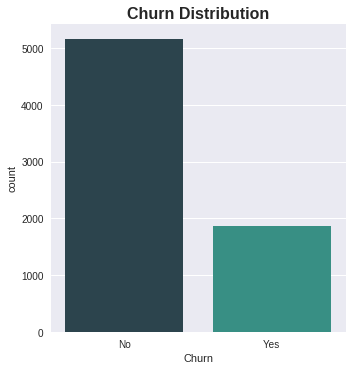

In [31]:
ax = sns.catplot(x="Churn", kind="count", data=data)
plt.title('Churn Distribution', weight='bold').set_fontsize('16');

As we can see our target is binary so our task is a binary classification, and the target is unblanced, we need to choose models that can handle this imbalance and choose the right metric.

### Personal Information
<a class="anchor" id="chapter2.1"></a>

Here we'll plot some visualization of the relations between the personal information and churn.

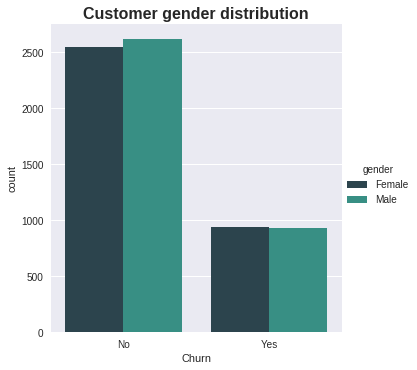

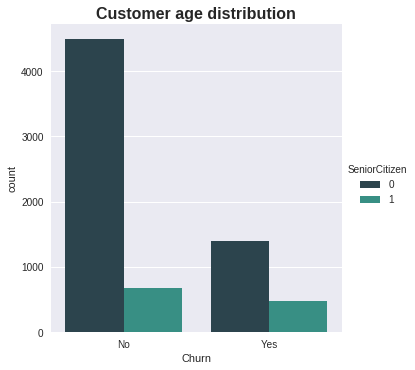

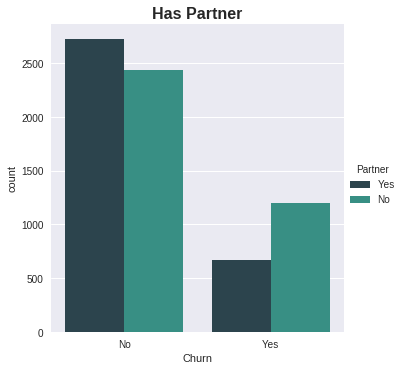

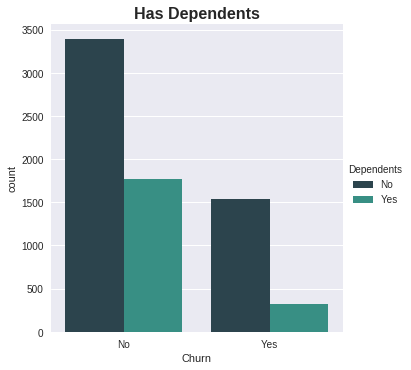

In [32]:
binary_features = {"gender" : "Customer gender distribution", 
                   "SeniorCitizen" : "Customer age distribution", 
                   "Partner" : "Has Partner", 
                   "Dependents" : "Has Dependents"}

# plot for all binary features
for k in binary_features:
    ax = sns.catplot(x="Churn", kind="count", data=data, hue = k)
    plt.title(binary_features[k], weight='bold').set_fontsize('16')
    plt.show();

- `Gender` - The churn rate is similar for both genders.
- `SeniorCitizen` - Despite having a small percentage out of all customers, senior citizens have a much higher churn rate. This means that churn is higher for senior citizens.
- `Partner` - Customers who have no partners are more likely to churn.
- `Dependents` - Customers who have no dependents are more likely to churn.

### Account Information
<a class="anchor" id="chapter2.2"></a>

Now we'll plot some visualization of the relations between the account information and churn.

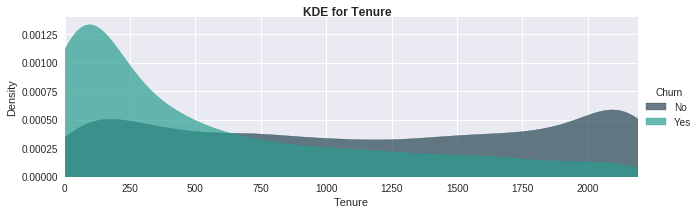

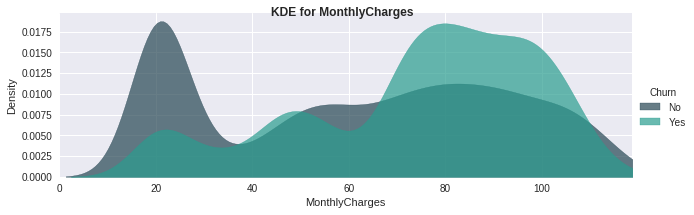

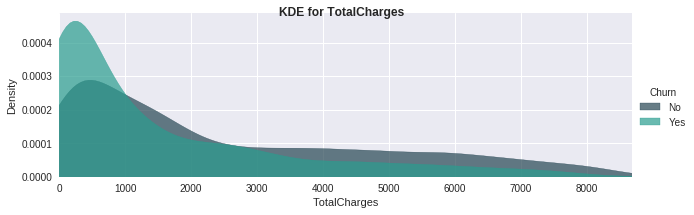

In [33]:
continues_features = ["Tenure", "MonthlyCharges", "TotalCharges"]
for item in continues_features:  
    s = sns.FacetGrid(data, hue = 'Churn', aspect = 3)
    s.map(sns.kdeplot, item, shade = True, alpha = 0.7)
    s.set(xlim=(0, data[item].max()))
    s.add_legend()
    s.set_axis_labels(item, 'Density')
    s.fig.suptitle(f"KDE for {item}", weight='bold')
    plt.show()

In [34]:
data.groupby('Churn')[['Tenure','MonthlyCharges','TotalCharges']].median()

,Tenure,MonthlyCharges,TotalCharges
Churn,,,
No,1157,64.45,1683.60
Yes,304,79.65,703.55


- `Tenure` - The median tenure for customers who have left is around 10 months (304 days), which means that recent clients are more likely to churn.
- `MonthlyCharges` - Monthly charges for customers who have left are usually higher and are around 80.
- `TotalCharges` - The median total charges of customers who have churned is very low, what correlates with the low tenure.

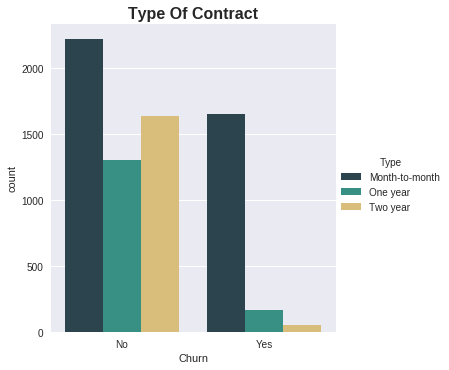

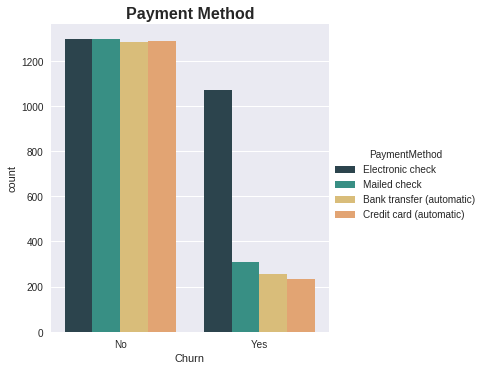

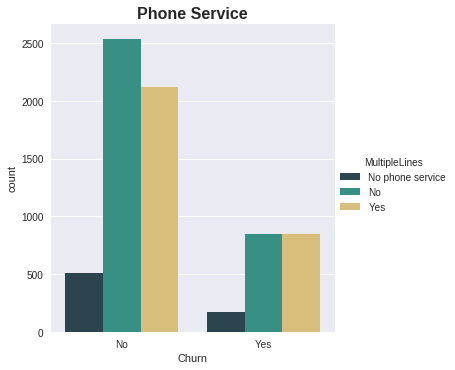

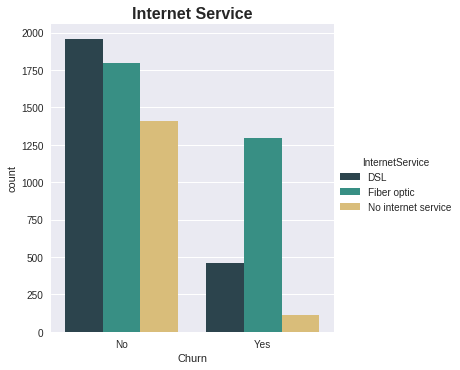

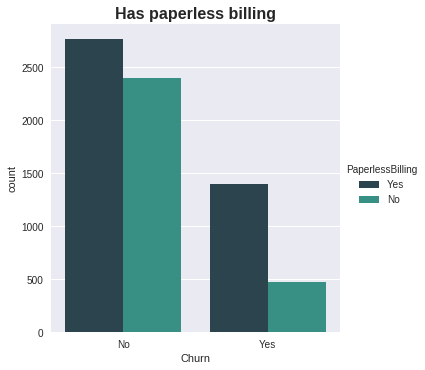

In [35]:
categorical_features = {"Type" : "Type Of Contract",
                        "PaymentMethod" : "Payment Method",
                        "MultipleLines" : "Phone Service",
                        "InternetService" : "Internet Service",
                        "PaperlessBilling" : "Has paperless billing"}

# plot for all categorical features
for k in categorical_features:
    ax = sns.catplot(x="Churn", kind="count", data=data, hue = k)
    plt.title(categorical_features[k], weight='bold').set_fontsize('16')
    plt.show();

- `Type` - In contrast to Customers on one or two year contracts, customers on monthly subscriptions are more likely to churn.
- `PaymentMethod` - Customers who have electronic check payment method are more likely to churn.
- `MultipleLines` - 
- `InternetService` - Churn rate is much higher for customers with Fiber optic internet services.
- `PaperlessBilling` - Customers who have paperless billing are more likely to churn.

In [36]:
palette1 = ["#001219", "#005f73", "#0a9396", "#94d2bd", "#e9d8a6", "#ee9b00", "#ca6702", "#bb3e03"]

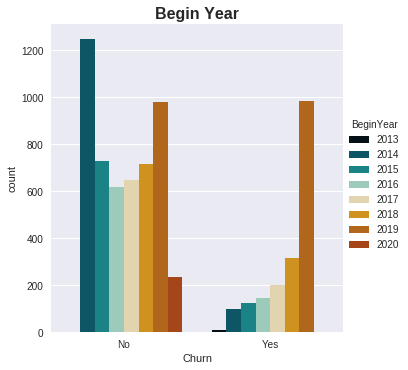

In [37]:
ax = sns.catplot(x="Churn", kind="count", data=data, hue = "BeginYear", palette=sns.color_palette(palette1))
plt.title("Begin Year", weight='bold').set_fontsize('16')
plt.show();

- `BeginYear` - The majority of customers who churned the company were those who signed up for its services in 2019.

### Additional services used by the customer
<a class="anchor" id="chapter2.3"></a>

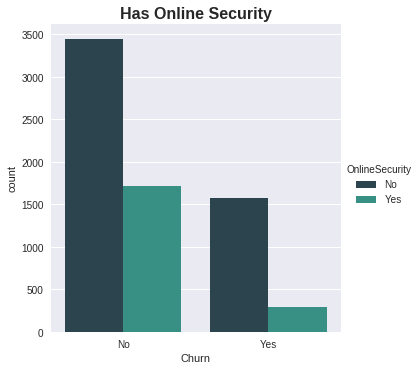

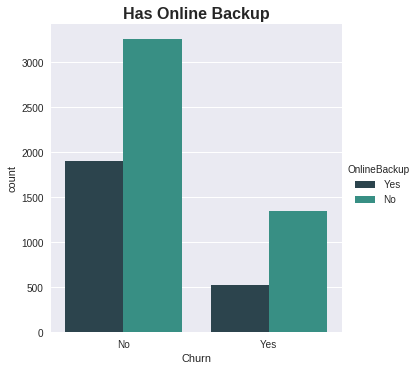

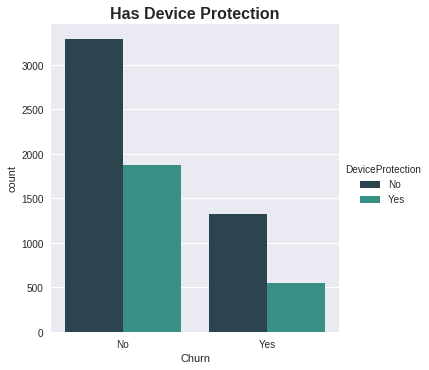

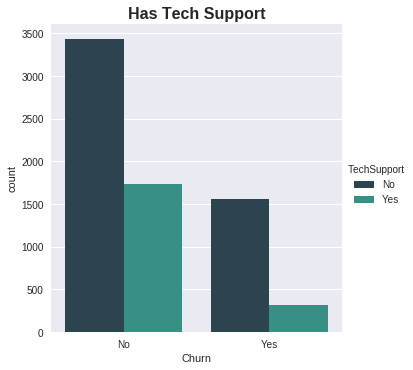

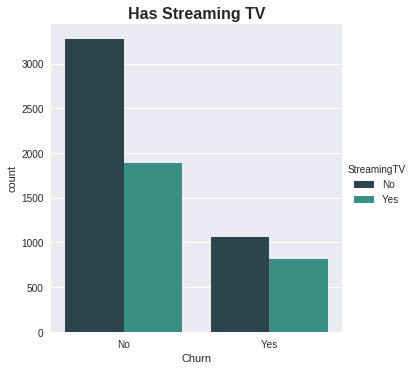

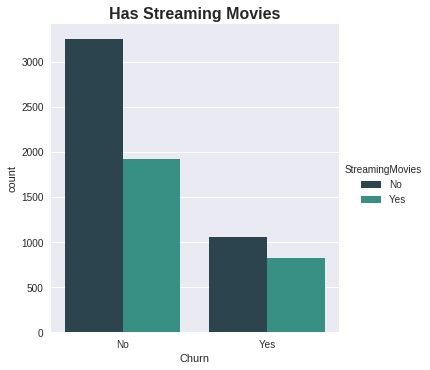

In [38]:
binary_features = {"OnlineSecurity" : "Has Online Security", 
                   "OnlineBackup" : "Has Online Backup", 
                   "DeviceProtection" : "Has Device Protection", 
                   "TechSupport" : "Has Tech Support",
                   "StreamingTV" : "Has Streaming TV",
                   "StreamingMovies" : "Has Streaming Movies"}

# plot for all binary features
for k in binary_features:
    ax = sns.catplot(x="Churn", kind="count", data=data, hue = k)
    plt.title(binary_features[k], weight='bold').set_fontsize('16')
    plt.show();

- `OnlineSecurity` - Customers who have no online security service are more likely to churn.
- `OnlineBackup` - Customers who have no online backup service are more likely to churn.
- `DeviceProtection` - Customers who have no device protection service are more likely to churn.
- `TechSupport` - Customers who have no tech support service are more likely to churn.
- `StreamingTV` - Customers with a Streaming TV service are more likely to churn.
- `StreamingMovies` - Customers with a Streaming Movies service are more likely to churn.

### Correlations between features and target
<a class="anchor" id="chapter2.4"></a>

For revealing the correlation of the categorical fatures with the target, we'll make a copy of the data and make some manipulations based on the results of the graphs above.
Binary features will be converted to numeric values of 0 and 1.
Categorical features will get the values in the ordere that were shown in the graphs.

In [39]:
data_copy = data.copy()

In [40]:
# list of binary features
binary_features = ["OnlineSecurity", "OnlineBackup" , "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
                   "Partner" , "Dependents" , "PaperlessBilling", "Churn"]

In [41]:
# encode the strings to numeric values
for f in binary_features:
    data_copy[f].replace(to_replace = {"Yes": 1, "No": 0}, inplace = True)

In [42]:
data_copy.gender.replace(to_replace = {"Male" : 0, "Female" : 1}, inplace = True)
data_copy.Type.replace(to_replace = {"Month-to-month" : 0, "One year" : 1, "Two year" : 2}, inplace = True)
data_copy.PaymentMethod.replace(to_replace = {"Electronic check" : 0, "Mailed check": 1, 
                                                 "Bank transfer (automatic)":2, "Credit card (automatic)":3}, inplace = True)
data_copy.MultipleLines.replace(to_replace = {"No phone service": 0, "No": 1, "Yes" : 2}, inplace = True)
data_copy.InternetService.replace(to_replace = {"No internet service" : 0, "DSL" :1, "Fiber optic" : 2}, inplace = True)

In [43]:
# find the correlations of the target with the features
churn_corr = data_copy.corr()['Churn'].sort_values(ascending = False)

In [44]:
# assign the red color for negative values and green for positive values
colors = ['red' if x < 0 else 'green' for x in churn_corr]

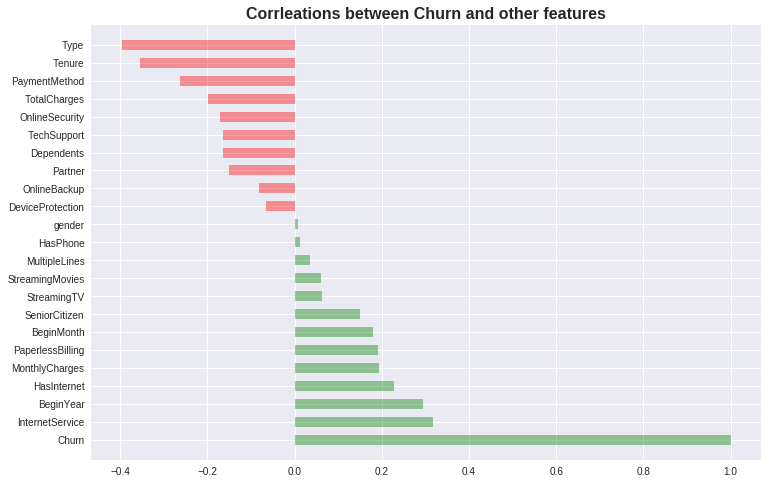

In [45]:
# plot the correlations
plt.figure(figsize=(12,8))
plt.hlines(y = churn_corr.index, xmin = 0, xmax= churn_corr, color = colors, alpha = 0.4, linewidth = 10);
plt.title('Corrleations between Churn and other features', weight='bold').set_fontsize('16');

Based on our analysis, we see that the following features are most correlated with the target:
`InternetService`, `BeginYear`, `HasInternet`, `Type`, `Tenure`, `PaymentMethod` and `TotalCharges`.

Now we want to see the correlations between the features themselves, and if there high correlation between the features, we will drop few of them.

In [46]:
data_copy[['Churn', 'InternetService', 'BeginYear', 'HasInternet', 'Type', 'Tenure','PaymentMethod', 'TotalCharges']].corr()

,Churn,InternetService,BeginYear,HasInternet,Type,Tenure,PaymentMethod,TotalCharges
Churn,1.000000,0.316350,0.293770,0.227578,-0.396150,-0.354496,-0.262918,-0.199484
InternetService,0.316350,1.000000,-0.055959,0.825625,-0.288855,0.031119,-0.178655,0.428212
BeginYear,0.293770,-0.055959,1.000000,-0.055637,-0.654961,-0.987425,-0.326365,-0.819304
HasInternet,0.227578,0.825625,-0.055637,1.000000,-0.241574,0.037417,-0.117927,0.374878
Type,-0.396150,-0.288855,-0.654961,-0.241574,1.000000,0.676787,0.359487,0.450306
Tenure,-0.354496,0.031119,-0.987425,0.037417,0.676787,1.000000,0.340997,0.825811
PaymentMethod,-0.262918,-0.178655,-0.326365,-0.117927,0.359487,0.340997,1.000000,0.222694
TotalCharges,-0.199484,0.428212,-0.819304,0.374878,0.450306,0.825811,0.222694,1.000000


As we can see, there is a high correlation between `Tenure` and `BeginYear` because it was calculated based on it, so we'll drop both cloumns, `BeginYear` and `BeginMonth` to avoid data leakage.

## Data preprocessing
***
<a class="anchor" id="chapter3"></a>

We will drop some columns as they are not relavant for our task. First of all we will drop the `customerID`. Also as the `Churn` column is a modified copy of the `EndDate` column, so we'll remove `EndDate` as well. The `BeginDate` was splitted to `BeginYear` and `BeginMonth` so we'll drop the original date and the relevant data still will be available. 
As we mentioned in the previous section, we have two features that are highly correlated with the `Tenure` feature and we'll drop them too (`BeginYear` and `BeginMonth`).

As we saw before, the task is a **Binary Classification Task**, and the target is unbalnced so we need to choose a balancing method, or use models that can handle imbalanced data.

In [47]:
# drop irrelevant columns
data = data.drop(['customerID','EndDate','BeginDate','BeginMonth','BeginYear'], axis = 1)

### Splitting dataset into traning and test sets
<a class="anchor" id="chapter3.1"></a>

In [48]:
# devide to target (y) and features (X), encode the target
y = data['Churn'].replace(to_replace = {"Yes": 1, "No": 0})
X = data.drop(['Churn'], axis = 1)

In [49]:
# split to train and test sets
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.25, random_state=123, stratify = y)

### Encoding and Scaling
<a class="anchor" id="chapter3.2"></a>

As our data has a lot of binary and categorical features, we need to encode them for the ML algorithms to work properly.
Also we need to scale the numeric features.

In [50]:
categorical_features = ['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'gender', 
                        'MultipleLines', 'OnlineBackup' ,'DeviceProtection', 'StreamingTV', 'StreamingMovies',
                        'PaymentMethod', 'HasPhone', 'HasInternet', 'InternetService','OnlineSecurity', 'TechSupport']

categorical_transformer = OneHotEncoder(drop='first')

numeric_features = ['MonthlyCharges','Tenure', 'TotalCharges']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[("cat", categorical_transformer, categorical_features),
                 ("num", numeric_transformer, numeric_features)],  remainder = 'passthrough'
)

## Model Building
***
<a class="anchor" id="chapter4"></a>

Before training the models, we want to see the features importance, based on RandomForest Classifier and decide which feature are most valuble for the models.

In [51]:
# encode the categorical features
X_fi = OneHotEncoder(drop='first').fit(X_train[categorical_features])
# get all features name after preprocessing
feature_names = np.append(X_fi.get_feature_names_out(categorical_features),numeric_features)

In [52]:
forest = RandomForestClassifier(random_state=0)
forest.fit(preprocessor.fit_transform(X_train), y_train)

RandomForestClassifier(random_state=0)

In [53]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

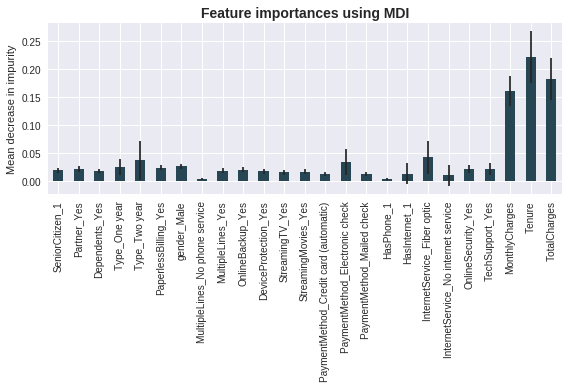

In [54]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI", weight='bold').set_fontsize('14');
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Based on this analysis and the correlation analysis, we will drop the following columns:
`gender`, `OnlineBackup` ,`DeviceProtection`, `StreamingTV`, `StreamingMovies` and `HasPhone`.

In [55]:
categorical_features = ['SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 
                        'MultipleLines','PaymentMethod', 'HasInternet', 'InternetService', 'OnlineSecurity', 'TechSupport']

As our task is a binary classification task and the target is unbalanced, we will use **ROC-AUC and F1 score**.

### Base model
<a class="anchor" id="chapter4.1"></a>

* Predicting the most frequent class

In [56]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", DummyClassifier(strategy='most_frequent', random_state=123))]
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(f"The ROC_AUC score: {roc_auc_score(y_test,pipe.predict_proba(X_test)[:, 1]):.3f}")
print(f"The F1 score: {f1_score(y_test,y_pred):.3f}")

The ROC_AUC score: 0.500
The F1 score: 0.000


In [57]:
# function for plotting roc-curve and confusion matrix
def plot_roc_cm(name, y_test, y_pred, pred_proba):
    fpr, tpr, roc_thresholds = roc_curve(y_test, pred_proba)
    roc_auc = roc_auc_score(y_test, pred_proba)    

    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
    axs[0].plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}' )
    axs[0].plot([0, 1], [0, 1], color='grey', linestyle='--')
    axs[0].set_xlabel('FPR')
    axs[0].set_ylabel('TPR')
    axs[0].legend(loc='lower center')        
    axs[0].set_title('ROC Curve', weight='bold', fontsize=13)

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=axs[1])
    plt.grid(None)
    axs[1].set_title(f"{name} Classifier Confusion Matrix",weight='bold',fontsize=13);

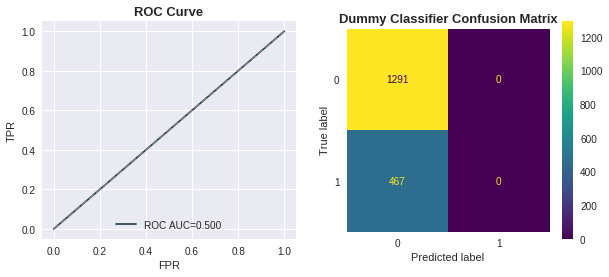

In [58]:
pred_proba = pipe.predict_proba(X_test)[:, 1]
plot_roc_cm('Dummy',y_test,y_pred,pred_proba)

### Logistic Regression Classifier
<a class="anchor" id="chapter4.2"></a>

In [59]:
# creating a pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", LogisticRegression(class_weight='balanced', random_state = 123))]
)

param_grid = {
    "clf__C" : [1, 10, 100, 1000]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = 'roc_auc')

grid.fit(X_train, y_train)

print("Best params:")
print(grid.best_params_)

print(f"Best ROC_AUC score: {grid.best_score_:.3f}")

Best params:
{'clf__C': 1000}
Best ROC_AUC score: 0.848


### Random Forest Classifier
<a class="anchor" id="chapter4.3"></a>

In [60]:
# creating a pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", RandomForestClassifier(class_weight = 'balanced', random_state=123))]
)

param_grid = {
    "clf__n_estimators" : [100, 200, 300],
    "clf__max_depth" : [8, 10, 15],
    "clf__max_leaf_nodes" : [30, 40, 50]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = 'roc_auc')

grid.fit(X_train, y_train)

print("Best params:")
print(grid.best_params_)

print(f"Best ROC_AUC score: {grid.best_score_:.3f}")

Best params:
{'clf__max_depth': 10, 'clf__max_leaf_nodes': 50, 'clf__n_estimators': 300}
Best ROC_AUC score: 0.862


### XGB Classifier
<a class="anchor" id="chapter4.4"></a>

In order to deal with the unbalanced data we need to define the scale_pos_weight which is the majority count devided by the minority count (0: 0.734, 1: 0.265).
**scale_pos_weight = neg_count/pos_count = 0.734/0.265 = 2.769**

In [61]:
# creating a pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", XGBClassifier(eval_metric= ["logloss"], 
                                                                 scale_pos_weight = 2.7 , random_state=123))]
)

param_grid = {
    "clf__learning_rate" : [0.05, 0.1, 0.2],
    "clf__n_estimators" : [100, 200, 300],
    "clf__max_depth" : [5, 8, 10]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = 'roc_auc')

grid.fit(X_train, y_train)

print("Best params:")
print(grid.best_params_)

print(f"Best ROC_AUC score: {grid.best_score_:.3f}")

Best params:
{'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 300}
Best ROC_AUC score: 0.901


### LGBM Classifier
<a class="anchor" id="chapter4.5"></a>

In [62]:
# creating a pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", LGBMClassifier(scale_pos_weight = 2.7, 
                                                                  metric = "binary_logloss", random_state=123))]
)

param_grid = {
    "clf__learning_rate" : [0.1, 0.2, 0.3], 
    "clf__n_estimators" : [500, 700, 1000],
    "clf__max_depth" : [3, 5, 8, 10, 12],
    "clf__lambda_l1" : [0, 1],
    "clf__lambda_l2" : [0, 1]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = 'roc_auc')

grid.fit(X_train, y_train)

print("Best params:")
print(grid.best_params_)

print(f"Best ROC_AUC score: {grid.best_score_:.3f}")

Best params:
{'clf__lambda_l1': 1, 'clf__lambda_l2': 0, 'clf__learning_rate': 0.2, 'clf__max_depth': 3, 'clf__n_estimators': 1000}
Best ROC_AUC score: 0.909


### Neural Network
<a class="anchor" id="chapter4.6"></a>

In order to deal with the unbalanced data, we need to define the class_weights parameter. We will do that using the compute_class_weight function.

In [63]:
classifier = Sequential()

# input layer and first hidden layer
classifier.add(Dense(6, activation='relu',input_dim = 25))

# second hidden layer
classifier.add(Dense(6, activation='relu'))

# output layer
classifier.add(Dense(1, activation = 'sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['AUC'])

In [64]:
# preprocess the training set
X_train_nn = preprocessor.fit_transform(X_train)

In [65]:
# calculate the class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y=y_train)

In [66]:
%%time
classifier.fit(
    X_train_nn, y_train, validation_split=0.2, class_weight = class_weights, batch_size = 32, epochs = 100, verbose=2)

Train on 4219 samples, validate on 1055 samples
Epoch 1/100
4219/4219 - 1s - loss: 0.5881 - AUC: 0.5787 - val_loss: 0.5020 - val_AUC: 0.7670
Epoch 2/100
4219/4219 - 1s - loss: 0.4723 - AUC: 0.7998 - val_loss: 0.4435 - val_AUC: 0.8201
Epoch 3/100
4219/4219 - 1s - loss: 0.4424 - AUC: 0.8252 - val_loss: 0.4291 - val_AUC: 0.8316
Epoch 4/100
4219/4219 - 1s - loss: 0.4325 - AUC: 0.8344 - val_loss: 0.4222 - val_AUC: 0.8380
Epoch 5/100
4219/4219 - 1s - loss: 0.4271 - AUC: 0.8391 - val_loss: 0.4202 - val_AUC: 0.8400
Epoch 6/100
4219/4219 - 1s - loss: 0.4234 - AUC: 0.8419 - val_loss: 0.4168 - val_AUC: 0.8437
Epoch 7/100
4219/4219 - 1s - loss: 0.4212 - AUC: 0.8441 - val_loss: 0.4164 - val_AUC: 0.8442
Epoch 8/100
4219/4219 - 1s - loss: 0.4188 - AUC: 0.8457 - val_loss: 0.4155 - val_AUC: 0.8450
Epoch 9/100
4219/4219 - 1s - loss: 0.4181 - AUC: 0.8464 - val_loss: 0.4146 - val_AUC: 0.8457
Epoch 10/100
4219/4219 - 1s - loss: 0.4166 - AUC: 0.8472 - val_loss: 0.4131 - val_AUC: 0.8472
Epoch 11/100
4219/421

## Model performances over training and test set
***
<a class="anchor" id="chapter5"></a>

For each model we will calculat AUC-ROC and F1 scores and plot ROC Curve and Confusion matrices.

**Logistic Regression**

In [67]:
%%time
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("clf", LogisticRegression(class_weight='balanced', C = 1000, random_state = 123))]
)
pipe = pipe.fit(X_train, y_train)

CPU times: user 155 ms, sys: 127 ms, total: 283 ms
Wall time: 284 ms


In [68]:
%%time
y_pred = pipe.predict(X_test)
print(f"The ROC_AUC score: {roc_auc_score(y_test,pipe.predict_proba(X_test)[:, 1]):.3f}")
print(f"The F1 score: {f1_score(y_test,y_pred):.3f}")

The ROC_AUC score: 0.837
The F1 score: 0.629
CPU times: user 141 ms, sys: 200 ms, total: 341 ms
Wall time: 390 ms


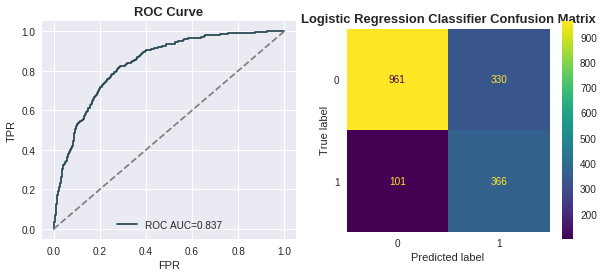

In [69]:
pred_proba = pipe.predict_proba(X_test)[:, 1]
plot_roc_cm('Logistic Regression',y_test,y_pred,pred_proba)

**Random Forest Classifier**

In [70]:
%%time
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("clf", RandomForestClassifier(n_estimators=300, max_depth=10, max_leaf_nodes=50, 
                                          class_weight = 'balanced', random_state=123))]
)
pipe = pipe.fit(X_train, y_train)

CPU times: user 1.07 s, sys: 3.23 ms, total: 1.07 s
Wall time: 1.08 s


In [71]:
%%time
y_pred = pipe.predict(X_test)
print(f"The ROC_AUC score: {roc_auc_score(y_test,pipe.predict_proba(X_test)[:, 1]):.3f}")
print(f"The F1 score: {f1_score(y_test,y_pred):.3f}")

The ROC_AUC score: 0.848
The F1 score: 0.644
CPU times: user 181 ms, sys: 142 µs, total: 181 ms
Wall time: 187 ms


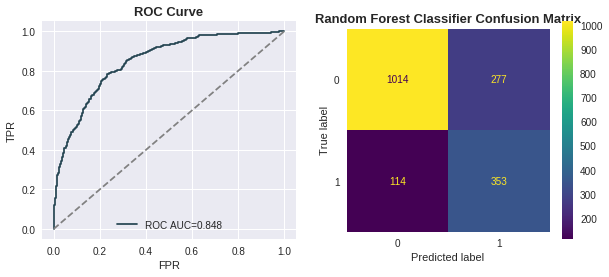

In [72]:
pred_proba = pipe.predict_proba(X_test)[:, 1]
plot_roc_cm('Random Forest',y_test,y_pred,pred_proba)

**XGB Classifier**

In [73]:
%%time
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("clf", XGBClassifier(learning_rate=0.2, n_estimators=300, max_depth=5, scale_pos_weight = 2.7,
                                 eval_metric = ["logloss"], random_state=123))]
)
pipe = pipe.fit(X_train, y_train)

CPU times: user 1.86 s, sys: 19.2 ms, total: 1.88 s
Wall time: 1.88 s


In [74]:
%%time
y_pred = pipe.predict(X_test)
print(f"The ROC_AUC score: {roc_auc_score(y_test,pipe.predict_proba(X_test)[:, 1]):.3f}")
print(f"The F1 score: {f1_score(y_test,y_pred):.3f}")

The ROC_AUC score: 0.897
The F1 score: 0.728
CPU times: user 86.5 ms, sys: 4.13 ms, total: 90.6 ms
Wall time: 87.9 ms


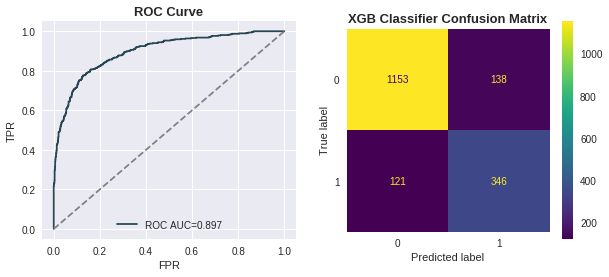

In [75]:
pred_proba = pipe.predict_proba(X_test)[:, 1]
plot_roc_cm('XGB',y_test,y_pred,pred_proba)

**LGBM Classifier**

In [83]:
%%time
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("clf", LGBMClassifier(scale_pos_weight = 2.7, metric = "binary_logloss", learning_rate = 0.2, max_depth = 3, 
                                  n_estimators = 700, lambda_l1 = 1, lambda_l2 = 0, random_state=123))]
)
pipe = pipe.fit(X_train, y_train)

CPU times: user 484 ms, sys: 3.58 ms, total: 488 ms
Wall time: 487 ms


In [84]:
%%time
y_pred = pipe.predict(X_test)
print(f"The ROC_AUC score: {roc_auc_score(y_test,pipe.predict_proba(X_test)[:, 1]):.3f}")
print(f"The F1 score: {f1_score(y_test,y_pred):.3f}")

The ROC_AUC score: 0.905
The F1 score: 0.733
CPU times: user 101 ms, sys: 3.84 ms, total: 105 ms
Wall time: 103 ms


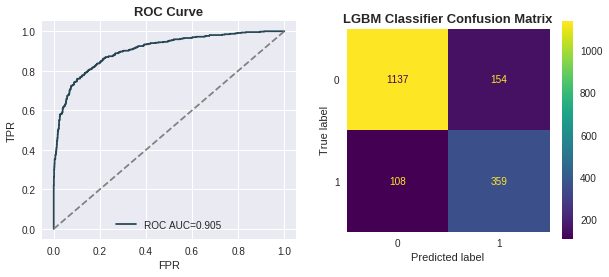

In [78]:
pred_proba = pipe.predict_proba(X_test)[:, 1]
plot_roc_cm('LGBM',y_test,y_pred,pred_proba)

**Neural Network**

In [79]:
%%time
X_test_nn = preprocessor.transform(X_test)
y_pred = classifier.predict_classes(X_test_nn)
print(f"The ROC_AUC score: {roc_auc_score(y_test,classifier.predict(X_test_nn)):.3f}")
print(f"The F1 score: {f1_score(y_test,y_pred):.3f}")

The ROC_AUC score: 0.834
The F1 score: 0.562
CPU times: user 219 ms, sys: 25.1 ms, total: 244 ms
Wall time: 248 ms


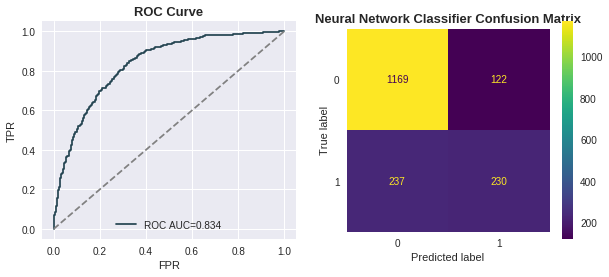

In [80]:
pred_proba = classifier.predict(X_test_nn)
plot_roc_cm('Neural Network',y_test,y_pred,pred_proba)

## Choosing the best model
***
<a class="anchor" id="chapter6"></a>

* **Logistic Regression**
    - `train time:` 620 ms  
    - `test time:` 132 ms  
    - `ROC-AUC:` 0.837  
    - `F1:` 0.629    
* **Random Forest Classifier**
    - `train time:` 1.1 s
    - `test time:` 254 ms
    - `ROC-AUC:` 0.848
    - `F1:` 0.644  
* **XGB Classifier**
    - `train time:` 1.7 s
    - `test time:` 81.5 ms
    - `ROC-AUC:` 0.897
    - `F1:` 0.728  
* **LGBM Classifier**
    - `train time:` 514 ms
    - `test time:` 107 ms
    - `ROC-AUC:` 0.905
    - `F1:` 0.733  
* **Neural Network Classifier**
    - `train time:` 56.4 s
    - `test time:` 197 ms
    - `ROC-AUC:` 0.831
    - `F1:` 0.524

The neural network was trained only for the sake of experience, but it is a heavy tool, and models have been found that provide a much better result.
The two leading models are XGB and LGBM Classifiers. Except the negligible difference in the test time, the **LGBM Clasiifier is the best model, with ROC-AUC score of 0.905 and F1 score of 0.733**.

## Conclusions
***
<a class="anchor" id="chapter7"></a>

We got 4 datasets containing client's personal data, contract information and information about Internet and Phone services. The aim of this project build a model that will be able to predict the churn of the clients.

The data was of a good quality, there were no missing values or duplicates, except the information about Total Charges for the very new customers that signed for the services in the same day the data was gathered (February 1, 2020).
The data contained 7043 unique customers, part of them have only one of the availble services (internet or phone) and the majority had them both.
We created some new features based on the existing -
- `Churn` - Our target value (values of Yes/No). Based on a copy of the EndDate.
- `Tenure` - Number of days the customer has a contract with the company. Calculated as the difference between the EndDate and BeginDate.
- `BeginMonth` and `BeginYear` - All the dates begin with the first of the month, so we can refer only to the month and the year.

We found there were 4 unique dates when customers left the services. 4 months in a row - October 2019 to January 2020. Information about new customer promotions, year-end specials, new companies entering the market, etc. would be helpful.

Based on our analysis, we found some features that were correlated with the target such as InternetService, BeginYear, Type, Tenure, PaymentMethod, TotalCharges.
We found that customers with Fiber-optic internet service are more likely to churn, as well as customers who signed for the services in the year of 2019, customers who has month-to-month cantract, new customers, customers who pay with an electronic check and customers with a high monthly charges.

We trained few models and compared them based on the ROC-AUC metric. **Our best model was LGBM Classifier with ROC-AUC score of 0.905 and F1 score of 0.733. (The hyperparameters are listed below: scale_pos_weight = 2.7, metric = "binary_logloss", learning_rate = 0.2, max_depth = 3, n_estimators = 700, lambda_l1 = 1, lambda_l2 = 0, random_state=123).**